# Peakfinder

## Introduction

This notebook takes input data from ASR-recordings in the form of an input folder with subfolders for each animal that contain their respective CSV files and outputs information regarding the average reaction of each animal to each experiment. <br>The code is annotated and a more extensive explanation is contained within `Protocol.md`. <br>The expected time it takes to run this notebook is roughly 30 seconds per recording, but this can be shorter or longer depending on your hardware and the specifics of the recording.

## Imports

If this is your first time running this, you need to install various python packages using pip. <br>
Open the terminal, either the windows command console or the VSC terminal. <br>
Now, run the command `pip install MODULENAME` for every module listed in the cell below (for example, `pip install pandas` to install pandas). Some of them may already be installed.

In [1]:
import pandas as pd       
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
from IPython.display import clear_output
import re
import ast

## Configuration

In [23]:
input_dir = "2025" # folder containing folders with .CSV files; subfolders are treated as animal numbers, files within them are treated as runs
                   # change this to your own input directory

output_dir = "Results" # folder containing final results

filename = "Output" # name of the output files

normalize = True # adjusts all values to be positive

verbose = False  # enables more output messages which can help identify problems; will only return errors if False

use_RMS = True # use RMS instead of raw strength

discard_late = True # discard late peaks from final output

discard_low = True # discard low peaks from final output

thresholds = [30, 25, 20, 15] # thresholds that are used to check for peaks

hard_threshold = 15 # if a peak is picked up below this, it will be counted as being too low 
                    # setting this to anything other than the lowest threshold should not be necessary unless you wish to see how many peaks
                    # land between the lowest threshold and the hard threshold

time_threshold = 50 # if a peak happens beyond this many miliseconds after the startle, it will be counted as being too late

length = 1000 # length of the time window for plotting in miliseconds (both before and after the startle);
              # needs to be 1000 for dual recordings to correct their startle times

example_number = 5 # index of the trial used for the example plot

In [3]:
# input startle times
# if there are multiple startles in one experiment, write their timestamps as a list
startle_times = {

    # new

    "ASR_control": 10000,
    "gap_depth": 10100,
    "gap_duration_10": 10060,
    "gap_duration_20": 10070,
    "gap_duration_4": 10054,
    "gap_duration_50": 10100,
    "gap_duration_8": 10058,
    "offset_ASR": 10010,
    "offset_PPI_10": 10010,
    "offset_PPI_12": 10012,
    "offset_PPI_14": 10014,
    "offset_PPI_16": 10016,
    "offset_PPI_18": 10018,
    "offset_PPI_20": 10020,
    "offset_PPI_4": 10004,
    "offset_PPI_6": 10006,
    "offset_PPI_8": 10008,
    "offset_PPI_50": 10050,
    "tone_in_noise": 10100,
    

    # old

    "ClassicalPrePulse": 60000,
    "Control_Startle": 10000,
    
    "DEPTH_50%": [1000, 21020],
    "DEPTH_75%": [1000, 21020],

    "Gap_PrePulse": 60000,
    
    "GAP10_50interval": [1000, 21020], 
    "GAP20_50interval": [1000, 21020], 
    "GAP30_50interval": [1000, 21020],
    "GAP4_50interval": [1000, 21020],
    "GAP40_50interval": [1000, 21020],
    "ISI100_duration50": [1000, 21020],
    "ISI150_duration50": [1000, 21020],
    "ISI20_duration50": [1000, 21020],
    "ISI50_duration50": [1000, 21020],

    "NoiseOffset_10ms": 10000, 
    "NoiseOffset_12ms": 10000, 
    "NoiseOffset_14ms": 10000, 
    "NoiseOffset_4ms": 10000, 
    "NoiseOffset_6ms": 10000,
    "NoiseOffset_8ms": 10000,
    "NoiseOffset_PrePulse": 10000,
    "NORMAL_PPI_100": 970,
    "NORMAL_PPI_20": 1000,
    "NORMAL_PPI_50": 1000,
    "NORMAL_PPL": 1000,

    "OFFSET_10": [1000, 21020],
    "OFFSET_12": [1000, 21020],
    "OFFSET_14": [1000, 21020],
    "OFFSET_16": [1000, 21020],
    "OFFSET_4": [1000, 21020],
    "OFFSET_6": [1000, 21020],
    "OFFSET_8": [1000, 21020]
    } 

if verbose: print(f"Raw startle times: {startle_times}")

for key, entry in startle_times.items():
    if isinstance(entry, list):
        entry[1] = entry[1] - 2*(entry[0] + length) # correct second startle time in dual recordings


if verbose: print(f"Adjusted startle times: {startle_times}")

In [4]:
# input sex
sex = {
    "1" : "female",
    "2" : "male",
    "4" : "male",
    "6" : "female",
    "10" : "female",
    "15" : "male"
}

In [5]:
# CSV file settings
data_start = 5 # row where the data starts

animal_column = 2       # column "Animal. No."
experiment_column = 8   # column "Exp. No."
number_column = 18      # column "TrialNo"
name_column = 17        # column "Trial"
time_column = 19        # column "MS"
value_column = 20       # column "ValueG"

# adjust columns to be 0-indexed
experiment_column, number_column, name_column, time_column, value_column = (x - 1 for x in (experiment_column, number_column, name_column, time_column, value_column))

## Slicing

In [6]:
segments = {}
startles = {}

backslash = "\\"

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.csv') or file.endswith('.CSV'):

            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, low_memory=False, skiprows=[0, 2])

            # Read animal number once per file (adjust row offset as needed)
            animal_row_index = data_start + 1  # for example
            animal_number = df.iloc[animal_row_index, animal_column]
            animal_str = f"Animal{animal_number}"

            current_segment = []
            previous_trial = None
            repetition = {}
            segment_time = 0

            for idx, row in df.iterrows():
                current_trial = row.iloc[name_column]

                if previous_trial is not None and current_trial != previous_trial:
                    if previous_trial not in repetition:
                        repetition[previous_trial] = 1
                    else:
                        repetition[previous_trial] += 1
                    
                    segment_df = pd.DataFrame(current_segment)

                    if isinstance(startle_times[previous_trial], list):
                        segment_startle = startle_times[previous_trial][0]
                        segment_name = f"{animal_str}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle1"

                        startles[segment_name] = segment_startle

                        split_index = segment_startle + length

                        first_half = segment_df.iloc[:split_index].copy().reset_index(drop=True)
                        second_half = segment_df.iloc[split_index:].copy().reset_index(drop=True)

                        second_half[0] = second_half[0] - second_half[0].iloc[0]

                        segments[segment_name] = first_half

                        if verbose: print(f"Processed {segment_name}.")

                        segment_startle = startle_times[previous_trial][1]
                        segment_name = f"{animal_str}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle2"

                        startles[segment_name] = segment_startle
                        segments[segment_name] = second_half

                        if verbose: print(f"Processed {segment_name}.")

                    else:
                        segment_startle = startle_times[previous_trial]
                        segment_name = f"{animal_str}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}"
                        segments[segment_name] = segment_df
                        startles[segment_name] = segment_startle
                        if verbose: print(f"Processed {segment_name}.")

                    current_segment = []
                    segment_time = 0

                # Append row to current segment
                if normalize:
                    current_segment.append([segment_time, float(abs(pd.to_numeric(row.iloc[value_column], errors='coerce')))])
                else:
                    current_segment.append([segment_time, float(row.iloc[value_column])])

                previous_trial = current_trial
                segment_time += 2

            # Save last segment (same animal_str)
            if current_segment:
                if previous_trial not in repetition:
                    repetition[previous_trial] = 1
                else:
                    repetition[previous_trial] += 1

                segment_df = pd.DataFrame(current_segment)

                if isinstance(startle_times[previous_trial], list):
                    segment_startle = startle_times[previous_trial][0]
                    segment_name = f"{animal_str}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle1"

                    startles[segment_name] = segment_startle

                    split_index = segment_startle + length

                    first_half = segment_df.iloc[:split_index].copy().reset_index(drop=True)
                    second_half = segment_df.iloc[split_index:].copy().reset_index(drop=True)

                    second_half[0] = second_half[0] - second_half[0].iloc[0]

                    segments[segment_name] = first_half

                    if verbose: print(f"Processed {segment_name}.")

                    segment_startle = startle_times[previous_trial][1]
                    segment_name = f"{animal_str}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle2"

                    startles[segment_name] = segment_startle
                    segments[segment_name] = second_half

                    if verbose: print(f"Processed {segment_name}.")

                else:
                    segment_startle = startle_times[previous_trial]
                    segment_name = f"{animal_str}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}"
                    segments[segment_name] = segment_df
                    startles[segment_name] = segment_startle
                    if verbose: print(f"Processed {segment_name}.")

# Print results
clear_output(wait=False)
key_names = ', '.join(segments.keys())
length = len(segments)
if verbose: print(f"\nCreated {length} entries:\n{key_names}")


In [7]:
# Cut the segments
adjusted_segments = {}
for entry in segments:
    df = segments[entry]
    reference_time = startles[entry]  

    # Filter the data to get rows within the 1000 ms before and after the reference time
    start_time = reference_time - length
    end_time = reference_time + length

    # Filter the dataframe to include only the data within the time range
    filtered_df = df[(df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] <= end_time)]

    # Adjust the time column to set the reference time to 0
    filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - reference_time

    filtered_df.reset_index(drop=True, inplace=True) 

    adjusted_segments[entry] = filtered_df

    if verbose: print(f"Adjusted {entry}.")

In [8]:
# Group keys by animal and date
animal_date_keys = defaultdict(list)

for key in adjusted_segments.keys():
    parts = key.split('_')
    animal = parts[0]
    date = parts[2]
    animal_date_keys[(animal, date)].append(key)

# Take first 10 keys per animal per date
top_10 = {}
for (animal, date), keys in animal_date_keys.items():
    first_10_keys = keys[:10]
    for k in first_10_keys:
        top_10[k] = adjusted_segments[k]

# Remove those entries from adjusted_segments
for key in top_10.keys():
    del adjusted_segments[key]

## Plotting

In [9]:
def plot_segments(name, segments, startles, threshold, adjust=True, hard=False):

    if adjust: # make the x-axis start with the startle
        df = adjusted_segments[name]
        startle_x = 0
    else:
        df = segments[name]
        startle_x = startles[name]

    median = np.median(df[1])
    

    if hard: # use hard or median threshold; purely cosmetic
        plot_threshold = threshold
    else:
        plot_threshold = threshold * median

    df = df.iloc[::2]  # only use every n-th value for plotting

    plot_title = name
    plt.figure(figsize=(8, 6))
    plt.plot(df[0], df[1], color="blue", marker="o", markersize=0)
    plt.axvline(x=startle_x, color='red', linewidth=2, linestyle='dotted', label="Startle")
    plt.axhline(y=plot_threshold, color='lime', linewidth=2, linestyle='dotted', label="Threshold")
    
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("ValueG", fontsize=12)
    plt.title(plot_title, fontsize=14)

    # Adjust y-ticks to be positive (if set in configuration) and spaced correctly 
    if normalize:
        y_ticks = range(0, int(df[1].max()) + 20, 20)
    else:
        y_ticks = range(int(df[1].min()) - 20, int(df[1].max()) + 20, 20)
    plt.yticks(y_ticks)

    
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()

    plt.show()

In [10]:
example_name =  list(adjusted_segments.keys())[example_number] # get example recording

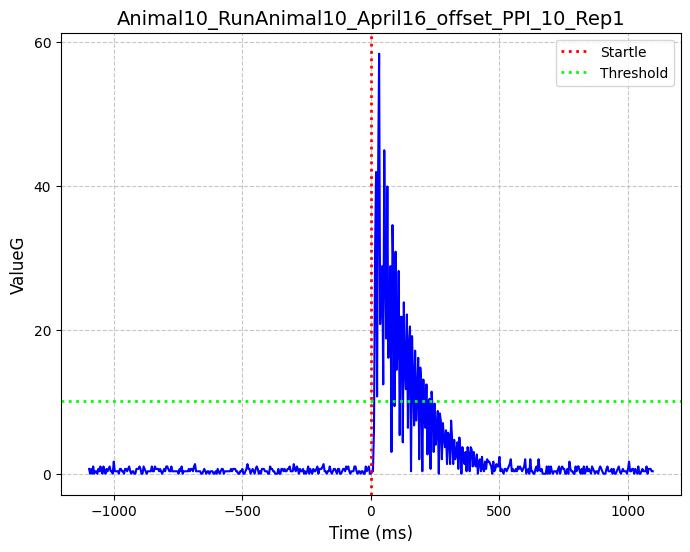

In [11]:
plot_segments(example_name, adjusted_segments, startles, threshold=15) 

## Analysis

In [12]:
reaction = {}
no_peaks = []

toolow = []
toolate = []

for entry in adjusted_segments:
    x = 0  # reset threshold index for each entry

    while x < len(thresholds):
        times = adjusted_segments[entry][0]
        values = adjusted_segments[entry][1]

        median = np.median(values)
        median_threshold = median * thresholds[x]

        indices_above_threshold = np.where((values > median_threshold) & (times > 0))[0]

        if len(indices_above_threshold) > 0:
            peak_start = times[indices_above_threshold[0]]  # first time a value passes the threshold
            start_value = values[indices_above_threshold[0]]  # first value that passes the threshold

            min_value = min(values[indices_above_threshold])  # minimum value among those above the threshold
            min_value_index = indices_above_threshold[np.argmin(values[indices_above_threshold])]
            min_time = times[min_value_index]

            max_value = max(values[indices_above_threshold])  # maximum value among those above the threshold
            max_value_index = indices_above_threshold[np.argmax(values[indices_above_threshold])]
            max_time = times[max_value_index]

            buildup = max_time - peak_start

            if use_RMS:
                rms_value = np.sqrt(np.mean(np.square(values[indices_above_threshold]))) # calculate RMS
            else:
                rms_value = max_value  # use max_value when RMS is not needed

            if max_value >= hard_threshold: # value above threshold
                if peak_start <= time_threshold: # value within time threshold
                    reaction[entry] = {
                        "reactionTime": int(peak_start),
                        "peakTime": int(max_time),
                        "difference": int(buildup),
                        "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                    }
                    if verbose: print(f"Processed {entry}.")
                else: # value outside of time threshold but within strength threshold
                    toolate.append(entry)
                    if not discard_late:
                        reaction[entry] = {
                            "reactionTime": int(peak_start),
                            "peakTime": int(max_time),
                            "difference": int(buildup),
                            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                        }
                        if verbose: print(f"Processed {entry}.")
            else: # value below strength threshold
                toolow.append(entry)
                if not discard_low:
                    reaction[entry] = {
                        "reactionTime": int(peak_start),
                        "peakTime": int(max_time),
                        "difference": int(buildup),
                        "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                    }
                    if verbose: print(f"Processed {entry}.")

                if peak_start >= time_threshold: # if outside of time threshold as well, append to that list too
                    toolate.append(entry)
                    if not discard_late:
                        reaction[entry] = {
                            "reactionTime": int(peak_start),
                            "peakTime": int(max_time),
                            "difference": int(buildup),
                            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                        }
                        if verbose: print(f"Processed {entry}.")

            break

        else:
            if x == len(thresholds) - 1: # give up after trying the lowest threshold
                no_peaks.append(entry)
                if verbose: print(f"No peak found for {entry} after trying all thresholds.")
                break  
            else:
                if verbose: print(f"Lowering threshold for {entry}.")
                x += 1  # try the next lower threshold

clear_output(wait=False)
reaction = {entry: data for entry, data in reaction.items() if data["reactionTime"] <= time_threshold} # remove late peaks
if verbose: print(f"Created {len(reaction)} entries.")



reaction_top_10 = {}
no_peaks_top_10 = []

toolow_top_10 = []
toolate_top_10 = []

for entry in top_10:  # use top_10 instead of adjusted_segments
    x = 0  # reset threshold index for each entry

    while x < len(thresholds):
        times = top_10[entry][0]
        values = top_10[entry][1]

        median = np.median(values)
        median_threshold = median * thresholds[x]

        indices_above_threshold = np.where((values > median_threshold) & (times > 0))[0]

        if len(indices_above_threshold) > 0:
            peak_start = times[indices_above_threshold[0]]  # first time a value passes the threshold
            start_value = values[indices_above_threshold[0]]  # first value that passes the threshold

            min_value = min(values[indices_above_threshold])  # minimum value among those above the threshold
            min_value_index = indices_above_threshold[np.argmin(values[indices_above_threshold])]
            min_time = times[min_value_index]

            max_value = max(values[indices_above_threshold])  # maximum value among those above the threshold
            max_value_index = indices_above_threshold[np.argmax(values[indices_above_threshold])]
            max_time = times[max_value_index]

            buildup = max_time - peak_start

            if use_RMS:
                rms_value = np.sqrt(np.mean(np.square(values[indices_above_threshold]))) # calculate RMS
            else:
                rms_value = max_value  # use max_value when RMS is not needed

            if max_value >= hard_threshold: # value above threshold
                if peak_start <= time_threshold: # value within time threshold
                    reaction_top_10[entry] = {
                        "reactionTime": int(peak_start),
                        "peakTime": int(max_time),
                        "difference": int(buildup),
                        "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                    }
                    if verbose: print(f"Processed {entry}.")
                else: # value outside of time threshold but within strength threshold
                    toolate_top_10.append(entry)
                    if not discard_late:
                        reaction_top_10[entry] = {
                            "reactionTime": int(peak_start),
                            "peakTime": int(max_time),
                            "difference": int(buildup),
                            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                        }
                        if verbose: print(f"Processed {entry}.")
            else: # value below strength threshold
                toolow_top_10.append(entry)
                if not discard_low:
                    reaction_top_10[entry] = {
                        "reactionTime": int(peak_start),
                        "peakTime": int(max_time),
                        "difference": int(buildup),
                        "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                    }
                    if verbose: print(f"Processed {entry}.")

                if peak_start >= time_threshold: # if outside of time threshold as well, append to that list too
                    toolate_top_10.append(entry)
                    if not discard_late:
                        reaction_top_10[entry] = {
                            "reactionTime": int(peak_start),
                            "peakTime": int(max_time),
                            "difference": int(buildup),
                            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
                        }
                        if verbose: print(f"Processed {entry}.")

            break

        else:
            if x == len(thresholds) - 1: # give up after trying the lowest threshold
                no_peaks_top_10.append(entry)
                if verbose: print(f"No peak found for {entry} after trying all thresholds.")
                break  
            else:
                if verbose: print(f"Lowering threshold for {entry}.")
                x += 1  # try the next lower threshold

clear_output(wait=False)

reaction_top_10 = {entry: data for entry, data in reaction_top_10.items() if data["reactionTime"] <= time_threshold}
if verbose: print(f"Created {len(reaction_top_10)} entries.")

## Saving

In [13]:
pattern = re.compile(r'^(?P<animal>\w+)_Run\w+_(?P<date>\w+?)_(?P<experiment>.+?)_Rep\d+$')

# Step 1: Group and average the data (original reaction)
intermediate = defaultdict(lambda: {
    "animal": [], "sex": [], "date": [], "reactionTime": [], "peakTime": [], "difference": [], "strength": []
})

for entry, values in reaction.items():
    parts = entry.split("_")
    animal = parts[0]
    date = parts[2]

    # Filter out parts like RepX, RunX
    experiment = [p for p in parts[1:] if not p.lower().startswith(('run', 'rep'))][1:]
    
    key = f"{animal}_{experiment}_{date}"  # unique key

    intermediate[key]["animal"].append(animal)
    intermediate[key]["date"].append(date)
    intermediate[key]["reactionTime"].append(values["reactionTime"])
    intermediate[key]["peakTime"].append(values["peakTime"])
    intermediate[key]["difference"].append(values["difference"])
    
    strength_value = values.get("strength (RMS)" if use_RMS else "strength (raw)", None)
    intermediate[key]["strength"].append(strength_value)

# Step 1b: Group and average the data (reaction_top_10)
intermediate_top_10 = defaultdict(lambda: {
    "animal": [], "sex": [], "date": [], "reactionTime": [], "peakTime": [], "difference": [], "strength": []
})

for entry, values in reaction_top_10.items():
    parts = entry.split("_")
    animal = parts[0]
    date = parts[2]

    # Filter out parts like RepX, RunX
    experiment = [p for p in parts[1:] if not p.lower().startswith(('run', 'rep'))][1:]
    
    key = f"{animal}_{experiment}_{date}"  # unique key

    intermediate_top_10[key]["animal"].append(animal)
    intermediate_top_10[key]["date"].append(date)
    intermediate_top_10[key]["reactionTime"].append(values["reactionTime"])
    intermediate_top_10[key]["peakTime"].append(values["peakTime"])
    intermediate_top_10[key]["difference"].append(values["difference"])
    
    strength_value = values.get("strength (RMS)" if use_RMS else "strength (raw)", None)
    intermediate_top_10[key]["strength"].append(strength_value)

In [14]:
averaged = []
for key, metrics in intermediate.items():
    animal, experiment, date = key.split("_", 2)
    averaged.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],  # get sex by animal number
        "date": date,
        "experiment": '_'.join(ast.literal_eval(experiment)),
        "reactionTime": round(sum(metrics["reactionTime"]) / len(metrics["reactionTime"]), 2),
        "peakTime": round(sum(metrics["peakTime"]) / len(metrics["peakTime"]), 2),
        "difference": round(sum(metrics["difference"]) / len(metrics["difference"]), 2),
        "strength": round(sum(metrics["strength"]) / len(metrics["strength"]), 2)
    })

# Same for intermediate_top_10
averaged_top_10 = []
for key, metrics in intermediate_top_10.items():
    animal, experiment, date = key.split("_", 2)
    averaged_top_10.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],  # get sex by animal number
        "date": date,
        "experiment": '_'.join(ast.literal_eval(experiment)),
        "reactionTime": round(sum(metrics["reactionTime"]) / len(metrics["reactionTime"]), 2),
        "peakTime": round(sum(metrics["peakTime"]) / len(metrics["peakTime"]), 2),
        "difference": round(sum(metrics["difference"]) / len(metrics["difference"]), 2),
        "strength": round(sum(metrics["strength"]) / len(metrics["strength"]), 2)
    })

In [15]:
def get_number(s):
    match = re.search(r'(\d+)$', s)  
    return int(match.group(1)) if match else None

def get_experiment_type(s):
    return re.sub(r'[_\s-]?\d+$', '', s)

def get_animal_number(s):
    match = re.search(r'(\d+)', s)
    return int(match.group(1)) if match else None

In [ ]:
os.makedirs(output_dir, exist_ok=True)

counter = 1
while os.path.exists(os.path.join(output_dir, str(counter))):
    counter += 1

subfolder_path = os.path.join(output_dir, str(counter))
os.makedirs(subfolder_path)

dfs = [pd.DataFrame(averaged), pd.DataFrame(averaged_top_10)]

# Sorting
for i, df in enumerate(dfs):
    df['has_number'] = df['experiment'].str.contains(r'\d+$')
    df['experiment_number'] = df['experiment'].apply(get_number)
    df['experiment_type'] = df['experiment'].apply(get_experiment_type)
    df['animal_number'] = df['animal'].apply(get_animal_number)

    df = df.sort_values(['date', 'animal_number', 'has_number', 'experiment_type', 'experiment_number'])

    df = df.drop(columns=['has_number', 'experiment_type', 'experiment_number', 'animal_number'])

    df = df.reset_index(drop=True)
    
    dfs[i] = df # redundant except if we use dfs somewhere else

    # Naming and saving
    file_suffix = "_Top_10" if i == 1 else ""
    output_path = os.path.join(subfolder_path, f"{filename}{file_suffix}.xlsx")

    df.to_excel(output_path, index=False)

print(f"Saved results to: {subfolder_path}")

Saved results to: Results\4


## Debugging

In [17]:
# Print out all trials containing faulty peaks; adjust as needed
if no_peaks: 
    print(f"Found no peaks in {len(no_peaks)+len(no_peaks_top_10)} recording(s):")
    print(no_peaks+no_peaks_top_10)
if toolow:
    print(f"Found insignificant peaks in {len(toolow)+len(toolow_top_10)} recording(s). They have been discarded.") if discard_low else print(f"Found insignificant peaks in {len(toolow)} recording(s):")
    print(toolow+toolow_top_10)
if toolate:
    print(f"Found late peaks in {len(toolate)+len(toolate_top_10)} recording(s). They have been discarded.") if discard_late else print(f"Found late peaks in {len(toolow)} recording(s):")
    print(toolate+toolate_top_10)

Found no peaks in 81 recording(s):
['Animal10_RunAnimal10_April16_offset_ASR_Rep2', 'Animal10_RunAnimal10_April16_offset_ASR_Rep3', 'Animal10_RunAnimal10_April16_offset_ASR_Rep4', 'Animal10_RunAnimal10_April16_offset_ASR_Rep5', 'Animal10_RunAnimal10_May20_offset_ASR_Rep2', 'Animal10_RunAnimal10_May20_offset_PPI_12_Rep2', 'Animal10_RunAnimal10_May20_offset_ASR_Rep3', 'Animal10_RunAnimal10_May20_offset_ASR_Rep4', 'Animal10_RunAnimal10_May20_offset_ASR_Rep5', 'Animal15_RunAnimal15_April16_offset_PPI_6_Rep2', 'Animal15_RunAnimal15_April16_offset_ASR_Rep2', 'Animal15_RunAnimal15_April16_offset_PPI_16_Rep2', 'Animal15_RunAnimal15_April16_offset_PPI_18_Rep3', 'Animal15_RunAnimal15_April16_offset_PPI_10_Rep3', 'Animal15_RunAnimal15_April16_offset_PPI_4_Rep1', 'Animal15_RunAnimal15_April16_offset_ASR_Rep3', 'Animal15_RunAnimal15_April16_offset_ASR_Rep4', 'Animal15_RunAnimal15_April16_offset_PPI_20_Rep3', 'Animal15_RunAnimal15_April16_tone_in_noise_Rep2', 'Animal15_RunAnimal15_April16_offset_ASR